In [5]:
!pip install -q transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm hdbscan sentence-transformers imbalanced-learn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

import hdbscan
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

print(" All libraries imported successfully")


 All libraries imported successfully


In [7]:
CSV_PATH = "studentdataset.csv"
df_raw = pd.read_csv(CSV_PATH)

print(f"{'='*80}")
print(f"RAW DATA INSPECTION")
print(f"{'='*80}")
print(f"Total rows: {len(df_raw)}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_raw.head())
print(f"\nData types:")
print(df_raw.dtypes)
print(f"\nMissing values:")
print(df_raw.isnull().sum())

RAW DATA INSPECTION
Total rows: 185

Columns: ['teaching', 'teaching.1', 'coursecontent', 'coursecontent.1', 'examination', 'Examination', 'labwork', 'labwork.1', 'library_facilities', ' library_facilities', 'extracurricular', 'extracurricular.1']

First few rows:
   teaching                                         teaching.1  coursecontent  \
0         0  teacher are punctual but they should also give...            0.0   
1         1                                              Good            -1.0   
2         1  Excellent lectures are delivered by teachers a...            1.0   
3         1                                               Good           -1.0   
4         1  teachers give us all the information required ...            1.0   

                                     coursecontent.1  examination  \
0                     content of courses are average          1.0   
1                                           Not good          1.0   
2  All courses material provide very good

In [8]:
print(f"\n{'='*80}")
print(f"COLUMN DETECTION")
print(f"{'='*80}")

text_candidates = [col for col in df_raw.columns if col.endswith('.1')]
print(f"Text columns detected: {text_candidates}")

rating_cols = [col for col in df_raw.columns
               if df_raw[col].dtype in (np.int64, np.float64) and not col.endswith('.1')]
print(f"Rating columns detected: {rating_cols}")

if not text_candidates:
    raise ValueError("No text columns ending with '.1' found!")
if not rating_cols:
    raise ValueError("No numeric rating columns found!")

print(f"\nRating distributions:")
for col in rating_cols:
    print(f"\n{col}:")
    print(df_raw[col].value_counts().sort_index())



COLUMN DETECTION
Text columns detected: ['teaching.1', 'coursecontent.1', 'labwork.1', 'extracurricular.1']
Rating columns detected: ['teaching', 'coursecontent', 'examination', 'labwork', 'library_facilities', 'extracurricular']

Rating distributions:

teaching:
teaching
-1     13
 0     35
 1    137
Name: count, dtype: int64

coursecontent:
coursecontent
-1.0     30
 0.0     26
 1.0    128
Name: count, dtype: int64

examination:
examination
-1.0     24
 0.0     30
 1.0    130
Name: count, dtype: int64

labwork:
labwork
-1     37
 0     16
 1    132
Name: count, dtype: int64

library_facilities:
library_facilities
-1.0     31
 0.0     24
 1.0    127
Name: count, dtype: int64

extracurricular:
extracurricular
-1     12
 0     19
 1    154
Name: count, dtype: int64


In [9]:
print(f"\n{'='*80}")
print(f"TEXT AND SENTIMENT PROCESSING")
print(f"{'='*80}")

TEXT_COL = "text"
LABEL_COL = "sentiment"

df = df_raw.copy()
df[TEXT_COL] = df[text_candidates].fillna("").astype(str).agg(" ".join, axis=1)
df[TEXT_COL] = df[TEXT_COL].str.replace(r"\s+", " ", regex=True).str.strip()

df["avg_rating"] = df_raw[rating_cols].mean(axis=1)

print(f"Average rating statistics:")
print(df["avg_rating"].describe())
print(f"\nRating distribution:")
print(df["avg_rating"].value_counts().sort_index())

# IMPROVED sentiment mapping with more balanced thresholds
def rating_to_sentiment(r):
    if pd.isna(r):
        return np.nan
    if r < 2.5:    # Stricter for negative
        return "Negative"
    if r < 3.8:    # Broader neutral range
        return "Neutral"
    return "Positive"

df[LABEL_COL] = df["avg_rating"].apply(rating_to_sentiment)

print(f"\nSentiment distribution BEFORE cleaning:")
print(df[LABEL_COL].value_counts(dropna=False))
print(f"\nPercentages:")
print(df[LABEL_COL].value_counts(normalize=True, dropna=False) * 100)



TEXT AND SENTIMENT PROCESSING
Average rating statistics:
count    185.000000
mean       0.599009
std        0.367490
min       -0.333333
25%        0.333333
50%        0.666667
75%        1.000000
max        1.000000
Name: avg_rating, dtype: float64

Rating distribution:
avg_rating
-0.333333     4
-0.166667     8
 0.000000     8
 0.166667    14
 0.333333    21
 0.500000    20
 0.600000     1
 0.666667    32
 0.750000     1
 0.800000     1
 0.833333    26
 1.000000    49
Name: count, dtype: int64

Sentiment distribution BEFORE cleaning:
sentiment
Negative    185
Name: count, dtype: int64

Percentages:
sentiment
Negative    100.0
Name: proportion, dtype: float64


In [10]:
print(f"\n{'='*80}")
print(f"DATA CLEANING")
print(f"{'='*80}")

initial_count = len(df)
print(f"Initial rows: {initial_count}")

# Remove rows with empty text
df = df[df[TEXT_COL].str.len() > 10].copy()
print(f"After removing short text: {len(df)} rows ({initial_count - len(df)} removed)")

df = df.dropna(subset=[LABEL_COL]).copy()
print(f"After removing missing sentiment: {len(df)} rows")

# Clean text and labels
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

print(f"\n{'='*80}")
print(f"FINAL SENTIMENT DISTRIBUTION")
print(f"{'='*80}")
label_counts = df[LABEL_COL].value_counts()
print("\nClass distribution:")
for lbl, cnt in label_counts.items():
    print(f"  {lbl:12}: {cnt:5} ({cnt/len(df)*100:6.2f}%)")

# Check if we have multiple classes
if len(label_counts) <= 1:
    print(f"\nWARNING: Only {len(label_counts)} class found!")
    print("This means all ratings fall into the same category.")
    print("Adjusting sentiment thresholds...")


    q33 = df["avg_rating"].quantile(0.33)
    q66 = df["avg_rating"].quantile(0.66)

    def rating_to_sentiment_balanced(r):
        if pd.isna(r): return np.nan
        if r <= q33: return "Negative"
        if r <= q66: return "Neutral"
        return "Positive"

    df[LABEL_COL] = df["avg_rating"].apply(rating_to_sentiment_balanced)
    print(f"\nAdjusted sentiment distribution (quantile-based):")
    print(df[LABEL_COL].value_counts())


DATA CLEANING
Initial rows: 185
After removing short text: 185 rows (0 removed)
After removing missing sentiment: 185 rows

FINAL SENTIMENT DISTRIBUTION

Class distribution:
  Negative    :   185 (100.00%)

This means all ratings fall into the same category.
Adjusting sentiment thresholds...

Adjusted sentiment distribution (quantile-based):
sentiment
Negative    75
Neutral     61
Positive    49
Name: count, dtype: int64



EXPLORATORY DATA ANALYSIS

Text length statistics:
  Mean: 168.0
  Median: 125.0
  Min: 15
  Max: 1377


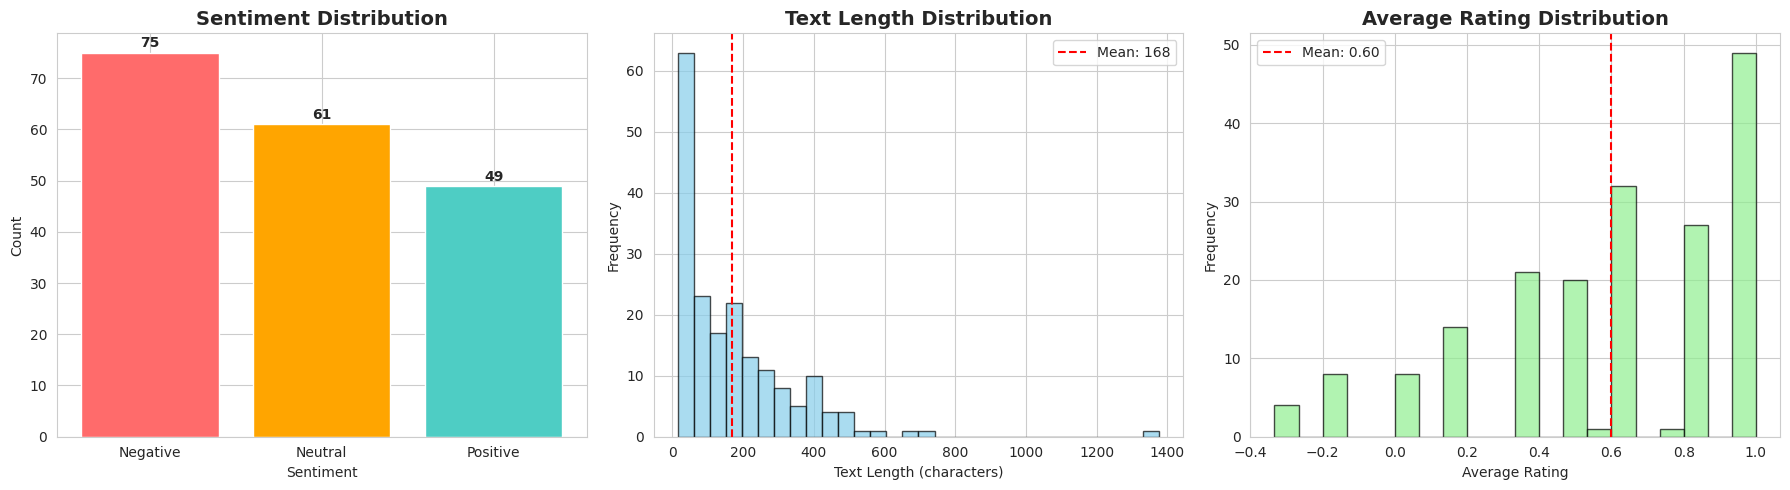

In [11]:
print(f"\n{'='*80}")
print(f"EXPLORATORY DATA ANALYSIS")
print(f"{'='*80}")

# Text length analysis
df['text_len'] = df[TEXT_COL].str.len()
print(f"\nText length statistics:")
print(f"  Mean: {df['text_len'].mean():.1f}")
print(f"  Median: {df['text_len'].median():.1f}")
print(f"  Min: {df['text_len'].min()}")
print(f"  Max: {df['text_len'].max()}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Label distribution
label_counts = df[LABEL_COL].value_counts()
colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
axes[0].bar(label_counts.index, label_counts.values, color=colors)
axes[0].set_title("Sentiment Distribution", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Sentiment")
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Plot 2: Text length distribution
axes[1].hist(df['text_len'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title("Text Length Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Text Length (characters)")
axes[1].set_ylabel("Frequency")
axes[1].axvline(df['text_len'].mean(), color='red', linestyle='--', label=f"Mean: {df['text_len'].mean():.0f}")
axes[1].legend()

# Plot 3: Rating distribution
axes[2].hist(df['avg_rating'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title("Average Rating Distribution", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Average Rating")
axes[2].set_ylabel("Frequency")
axes[2].axvline(df['avg_rating'].mean(), color='red', linestyle='--', label=f"Mean: {df['avg_rating'].mean():.2f}")
axes[2].legend()

plt.tight_layout()
plt.show()


In [12]:
print(f"\n{'='*80}")
print(f"COMPUTING SENTENCE EMBEDDINGS")
print(f"{'='*80}")

embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("Encoding texts to embeddings...")
embeddings = embedder.encode(
    df[TEXT_COL].tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)
print(f"✓ Embeddings shape: {embeddings.shape}")

# Dimensionality reduction for visualization
print("\nReducing dimensions with PCA...")
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)
print(f"✓ 2D embeddings shape: {emb_2d.shape}")
print(f"  Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")



COMPUTING SENTENCE EMBEDDINGS


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding texts to embeddings...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Embeddings shape: (185, 384)

Reducing dimensions with PCA...
✓ 2D embeddings shape: (185, 2)
  Explained variance: 34.36%


In [13]:
print(f"\n{'='*80}")
print(f"OUTLIER DETECTION - ISOLATION FOREST")
print(f"{'='*80}")

# Isolation Forest for global outliers
iso = IsolationForest(
    contamination=0.08,  # Expect ~8% outliers
    random_state=42,
    n_estimators=200
)
iso_labels = iso.fit_predict(embeddings)
outliers_idx = np.where(iso_labels == -1)[0]

print(f"  Found {len(outliers_idx)} outliers ({len(outliers_idx)/len(df)*100:.2f}%)")
print(f"  Normal samples: {(iso_labels == 1).sum()}")
print(f"  Outlier samples: {(iso_labels == -1).sum()}")

# Outlier sentiment distribution
outlier_sentiments = df.iloc[outliers_idx][LABEL_COL].value_counts()
print(f"\nOutlier sentiment distribution:")
for lbl, cnt in outlier_sentiments.items():
    print(f"  {lbl}: {cnt} ({cnt/len(outliers_idx)*100:.1f}%)")



OUTLIER DETECTION - ISOLATION FOREST
  Found 15 outliers (8.11%)
  Normal samples: 170
  Outlier samples: 15

Outlier sentiment distribution:
  Negative: 10 (66.7%)
  Positive: 4 (26.7%)
  Neutral: 1 (6.7%)


In [14]:
print(f"\n{'='*80}")
print(f"DENSITY-BASED CLUSTERING - HDBSCAN")
print(f"{'='*80}")

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=max(5, len(df)//50),  # Adaptive cluster size
    min_samples=3,
    metric='euclidean',
    cluster_selection_epsilon=0.0
)
cluster_labels = clusterer.fit_predict(embeddings)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"  Found {n_clusters} clusters")
print(f"  Noise points: {n_noise} ({n_noise/len(df)*100:.1f}%)")

# Cluster size analysis
cluster_sizes = Counter(cluster_labels)
print(f"\nCluster sizes:")
for cid in sorted(cluster_sizes.keys()):
    size = cluster_sizes[cid]
    if cid == -1:
        print(f"  Noise: {size}")
    else:
        print(f"  Cluster {cid}: {size} samples")

# Identify minority clusters (small clusters)
minority_threshold = max(10, len(df) // 20)  # Adaptive threshold
minority_cluster_ids = [c for c, size in cluster_sizes.items()
                        if c != -1 and size < minority_threshold]
minority_cluster_idx = np.isin(cluster_labels, minority_cluster_ids)

print(f"\n Identified {len(minority_cluster_ids)} MINORITY clusters")
print(f"  Threshold: clusters with < {minority_threshold} samples")
print(f"  Total minority samples: {minority_cluster_idx.sum()} ({minority_cluster_idx.sum()/len(df)*100:.1f}%)")



DENSITY-BASED CLUSTERING - HDBSCAN
  Found 3 clusters
  Noise points: 39 (21.1%)

Cluster sizes:
  Noise: 39
  Cluster 0: 99 samples
  Cluster 1: 9 samples
  Cluster 2: 38 samples

 Identified 1 MINORITY clusters
  Threshold: clusters with < 10 samples
  Total minority samples: 9 (4.9%)



VISUALIZATION: EMBEDDING SPACE


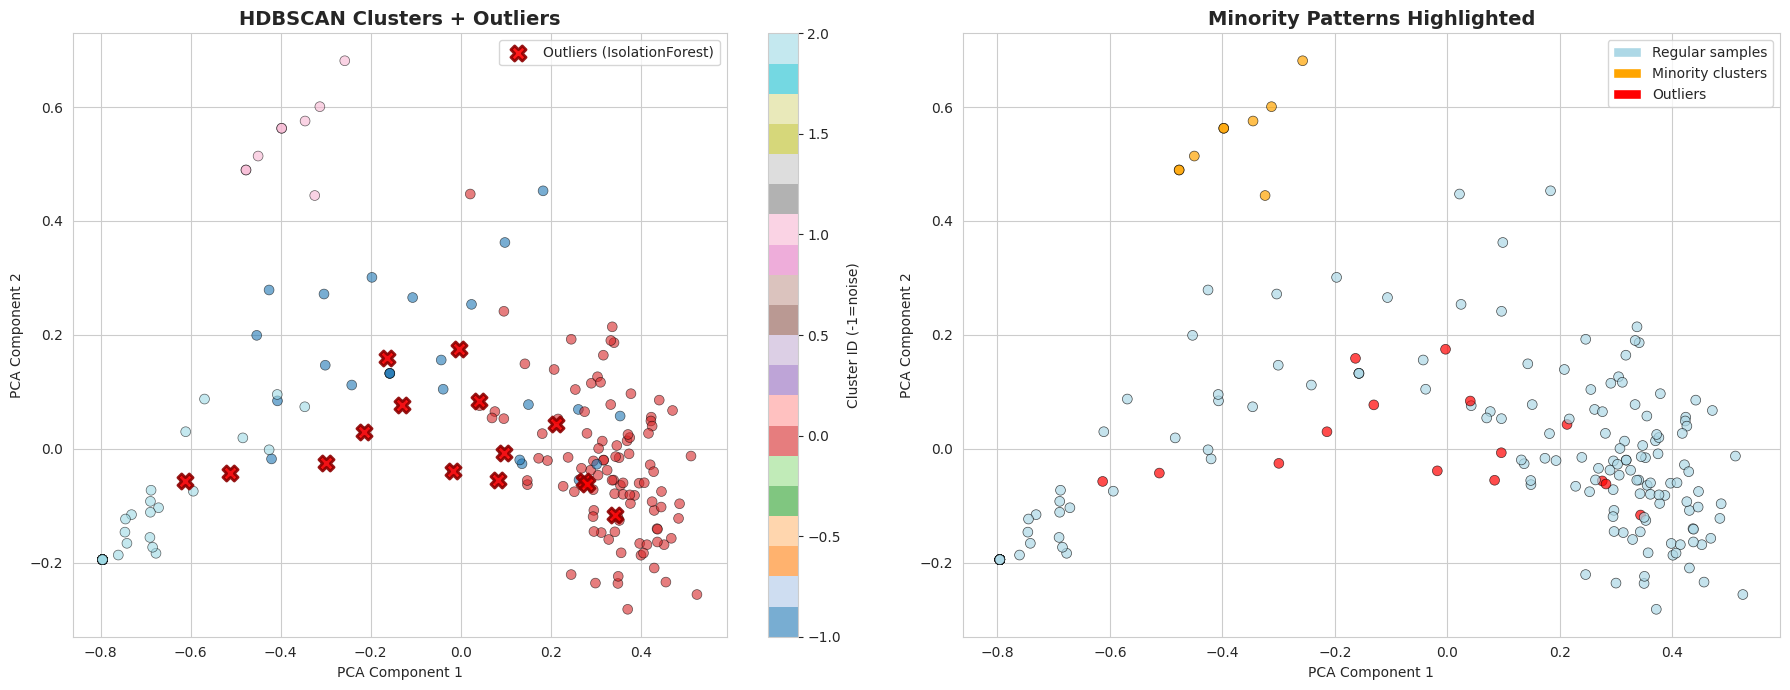

In [15]:
print(f"\n{'='*80}")
print(f"VISUALIZATION: EMBEDDING SPACE")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Clusters
scatter1 = axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1],
                           c=cluster_labels, cmap='tab20',
                           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].scatter(emb_2d[outliers_idx, 0], emb_2d[outliers_idx, 1],
                c='red', s=120, marker='X',
                linewidths=2, label='Outliers (IsolationForest)',
                edgecolors='darkred', alpha=0.9)
axes[0].set_title("HDBSCAN Clusters + Outliers", fontsize=14, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(loc='best')
plt.colorbar(scatter1, ax=axes[0], label="Cluster ID (-1=noise)")

# Plot 2: Minority patterns highlighted
colors_minority = ['lightblue' if not minority_cluster_idx[i] and i not in outliers_idx
                   else 'orange' if minority_cluster_idx[i]
                   else 'red' for i in range(len(df))]
axes[1].scatter(emb_2d[:, 0], emb_2d[:, 1],
                c=colors_minority, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_title("Minority Patterns Highlighted", fontsize=14, fontweight='bold')
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', label='Regular samples'),
    Patch(facecolor='orange', label='Minority clusters'),
    Patch(facecolor='red', label='Outliers')
]
axes[1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

In [16]:
print(f"\n{'='*80}")
print(f"TOP 15 RARE FEEDBACK PATTERNS")
print(f"{'='*80}")

# Combine all minority patterns
all_minority_idx = np.union1d(outliers_idx, np.where(minority_cluster_idx)[0])
print(f"Total minority patterns: {len(all_minority_idx)} ({len(all_minority_idx)/len(df)*100:.1f}%)")

if len(all_minority_idx) > 0:
    # Sample up to 15 examples
    sample_size = min(15, len(all_minority_idx))
    sampled_idx = np.random.choice(all_minority_idx, size=sample_size, replace=False)

    for i, idx in enumerate(sampled_idx, 1):
        text = df.iloc[idx][TEXT_COL]
        sentiment = df.iloc[idx][LABEL_COL]
        cluster_id = cluster_labels[idx]
        is_outlier = idx in outliers_idx
        is_minority_cluster = idx in np.where(minority_cluster_idx)[0]

        print(f"\n{'─'*80}")
        print(f"Example {i}:")
        print(f"  Type: {'Outlier' if is_outlier else 'Minority Cluster'}")
        print(f"  Cluster ID: {cluster_id}")
        print(f"  Sentiment: {sentiment}")
        print(f"  Text: {text[:250]}{'...' if len(text) > 250 else ''}")
else:
    print("  No minority patterns found. Dataset may be too homogeneous.")


TOP 15 RARE FEEDBACK PATTERNS
Total minority patterns: 24 (13.0%)

────────────────────────────────────────────────────────────────────────────────
Example 1:
  Type: Outlier
  Cluster ID: -1
  Sentiment: Negative
  Text: Perfect Awesome Too much lanlb file work Perfect

────────────────────────────────────────────────────────────────────────────────
Example 2:
  Type: Minority Cluster
  Cluster ID: 1
  Sentiment: Neutral
  Text: average good good good

────────────────────────────────────────────────────────────────────────────────
Example 3:
  Type: Minority Cluster
  Cluster ID: 1
  Sentiment: Neutral
  Text: good well planned average good

────────────────────────────────────────────────────────────────────────────────
Example 4:
  Type: Minority Cluster
  Cluster ID: 1
  Sentiment: Neutral
  Text: average good good good

────────────────────────────────────────────────────────────────────────────────
Example 5:
  Type: Outlier
  Cluster ID: -1
  Sentiment: Negative
  Text: nice g

In [17]:
print(f"\n{'='*80}")
print(f"PREPARING DATA FOR SUPERVISED LEARNING")
print(f"{'='*80}")

# Label encoding
unique_labels = sorted(df[LABEL_COL].unique())
label2id = {lbl: i for i, lbl in enumerate(unique_labels)}
id2label = {i: lbl for lbl, i in label2id.items()}
df['label_id'] = df[LABEL_COL].map(label2id)

print(f"Label mapping:")
for lbl, idx in label2id.items():
    print(f"  {lbl} → {idx}")

X = df[TEXT_COL].tolist()
y = df['label_id'].tolist()

print(f"\nTotal samples: {len(X)}")
print(f"Number of classes: {len(unique_labels)}")

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTrain/Val split:")
print(f"  Training: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples")

# Class distribution in train/val
print(f"\nTraining set distribution:")
for idx, lbl in id2label.items():
    count = Counter(y_train)[idx]
    print(f"  {lbl}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nValidation set distribution:")
for idx, lbl in id2label.items():
    count = Counter(y_val)[idx]
    print(f"  {lbl}: {count} ({count/len(y_val)*100:.1f}%)")



PREPARING DATA FOR SUPERVISED LEARNING
Label mapping:
  Negative → 0
  Neutral → 1
  Positive → 2

Total samples: 185
Number of classes: 3

Train/Val split:
  Training: 148 samples
  Validation: 37 samples

Training set distribution:
  Negative: 60 (40.5%)
  Neutral: 49 (33.1%)
  Positive: 39 (26.4%)

Validation set distribution:
  Negative: 15 (40.5%)
  Neutral: 12 (32.4%)
  Positive: 10 (27.0%)


In [18]:
print(f"\n{'='*80}")
print(f"CREATING PYTORCH DATASETS")
print(f"{'='*80}")

MODEL_NAME = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Loaded tokenizer: {MODEL_NAME}")

class FeedbackDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx].clone().detach() for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_ds = FeedbackDataset(X_train, y_train)
val_ds = FeedbackDataset(X_val, y_val)

print(f" Training dataset: {len(train_ds)} samples")
print(f" Validation dataset: {len(val_ds)} samples")



CREATING PYTORCH DATASETS


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ Loaded tokenizer: distilroberta-base
 Training dataset: 148 samples
 Validation dataset: 37 samples


In [19]:
print(f"\n{'='*80}")
print(f"COMPUTING CLASS WEIGHTS (FOR MINORITY PROTECTION)")
print(f"{'='*80}")

classes_in_train = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes_in_train, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class weights (higher = more focus):")
for idx, lbl in id2label.items():
    if idx in classes_in_train:
        weight_idx = np.where(classes_in_train == idx)[0][0]
        print(f"  {lbl}: {class_weights[weight_idx]:.3f}")

# Identify minority classes
train_class_counts = Counter(y_train)
max_count = max(train_class_counts.values())
minority_class_ids = [i for i, count in train_class_counts.items() if count < max_count]

print(f"\nMinority classes (will be protected during training):")
for idx in minority_class_ids:
    print(f"  {id2label[idx]}: {train_class_counts[idx]} samples")



COMPUTING CLASS WEIGHTS (FOR MINORITY PROTECTION)
Class weights (higher = more focus):
  Negative: 0.822
  Neutral: 1.007
  Positive: 1.265

Minority classes (will be protected during training):
  Positive: 39 samples
  Neutral: 49 samples


In [20]:
print(f"\n{'='*80}")
print(f"SETTING UP MODEL AND TRAINER")
print(f"{'='*80}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)
print(f"✓ Loaded model: {MODEL_NAME}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Custom metrics with minority focus
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    unique_eval_labels = np.unique(labels)
    report = classification_report(
        labels, preds,
        labels=unique_eval_labels,
        output_dict=True,
        zero_division=0
    )

    macro = report['macro avg']['f1-score']
    weighted = report['weighted avg']['f1-score']

    # Calculate minority F1
    if len(unique_eval_labels) <= 1 or len(minority_class_ids) == 0:
        minority_f1 = 0.0
    else:
        minority_f1_scores = []
        for i in minority_class_ids:
            if str(i) in report and i in unique_eval_labels:
                minority_f1_scores.append(report[str(i)]['f1-score'])
        minority_f1 = np.mean(minority_f1_scores) if minority_f1_scores else 0.0

    return {
        "f1_macro": macro,
        "f1_weighted": weighted,
        "minority_f1_mean": minority_f1,
    }

# Custom Trainer with weighted loss - FIXED
class BalancedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Accept and ignore num_items_in_batch
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, len(unique_labels)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Optimizer with differential learning rates
def get_optimizer(model):
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                      if not any(nd in n for nd in no_decay) and "classifier" not in n],
            "lr": 1e-5,
            "weight_decay": 0.01
        },
        {
            "params": [p for n, p in model.named_parameters()
                      if any(nd in n for nd in no_decay) and "classifier" not in n],
            "lr": 1e-5,
            "weight_decay": 0.0
        },
        {
            "params": [p for n, p in model.named_parameters() if "classifier" in n],
            "lr": 1e-3,
            "weight_decay": 0.01
        },
    ]
    return AdamW(optimizer_grouped_parameters)

print("✓ Custom trainer and optimizer configured")


SETTING UP MODEL AND TRAINER


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded model: distilroberta-base
  Parameters: 82,120,707
✓ Custom trainer and optimizer configured


In [21]:
print(f"\n{'='*80}")
print(f"TRAINING CONFIGURATION")
print(f"{'='*80}")

training_args = TrainingArguments(
    output_dir="./feedback_model",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="minority_f1_mean",
    greater_is_better=True,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to=[],
    save_total_limit=2,
    seed=42,
)

print(f"Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup ratio: {training_args.warmup_ratio}")
print(f"  FP16: {training_args.fp16}")
print(f"  Best model metric: {training_args.metric_for_best_model}")

trainer = BalancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
    optimizers=(get_optimizer(model), None),
)

print(" Trainer initialized")


TRAINING CONFIGURATION
Training configuration:
  Epochs: 15
  Batch size: 16
  Learning rate: 3e-05
  Warmup ratio: 0.1
  FP16: True
  Best model metric: minority_f1_mean
 Trainer initialized


In [22]:
print(f"\n{'='*80}")
print(f"STARTING TRAINING")
print(f"{'='*80}\n")

trainer.train()

print(f"\n{'='*80}")
print(f" TRAINING COMPLETED")
print(f"{'='*80}")


STARTING TRAINING



Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Minority F1 Mean
1,1.104700,1.068174,0.226580,0.215510,0.222222
2,1.105500,0.975075,0.574595,0.573996,0.508951
3,1.005600,0.891025,0.630762,0.628953,0.591304
4,0.889500,0.824219,0.591822,0.593755,0.516304
5,0.768400,0.810242,0.587670,0.590410,0.526667
6,0.647900,0.797425,0.597594,0.613528,0.502451
7,0.548500,0.812480,0.671644,0.675070,0.613527
8,0.408400,0.858036,0.555078,0.567587,0.477778
9,0.370100,0.918103,0.630762,0.628953,0.591304
10,0.304400,0.922989,0.625758,0.630344,0.563636



 TRAINING COMPLETED


In [23]:
print(f"\n{'='*80}")
print(f"FINAL MODEL EVALUATION")
print(f"{'='*80}")

results = trainer.evaluate()
print(f"\nValidation Metrics:")
for k, v in results.items():
    if 'runtime' not in k and 'per_second' not in k:
        print(f"  {k:30}: {v:.4f}")


FINAL MODEL EVALUATION



Validation Metrics:
  eval_loss                     : 0.8125
  eval_f1_macro                 : 0.6716
  eval_f1_weighted              : 0.6751
  eval_minority_f1_mean         : 0.6135
  epoch                         : 11.0000


In [24]:
print(f"\n{'='*80}")
print(f"DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")

preds = trainer.predict(val_ds).predictions
pred_labels = np.argmax(preds, axis=1)

print("\nPer-class metrics:")
print(classification_report(y_val, pred_labels, target_names=unique_labels, digits=4))

# Per-class F1 scores
f1_per_class = {}
# Calculate F1 scores for all classes at once
f1_scores_all = f1_score(y_val, pred_labels, average=None, zero_division=0)

for i, label in enumerate(unique_labels):
    # Check if the class is present in y_val before trying to access its F1 score
    if i in np.unique(y_val):
        f1 = f1_scores_all[i]
        f1_per_class[label] = f1
        # Determine if the class is a minority class based on the training set distribution
        class_type = "MINORITY" if i in minority_class_ids else "MAJORITY"
        print(f"  {label} ({class_type}): F1 = {f1:.4f}")
    else:
        # If a class is not present in y_val, print that it's not in the validation set
        class_type = "MINORITY" if i in minority_class_ids else "MAJORITY"
        print(f"  {label} ({class_type}): Not in validation set")


DETAILED CLASSIFICATION REPORT



Per-class metrics:
              precision    recall  f1-score   support

    Negative     0.7222    0.8667    0.7879        15
     Neutral     0.6667    0.3333    0.4444        12
    Positive     0.6923    0.9000    0.7826        10

    accuracy                         0.7027        37
   macro avg     0.6937    0.7000    0.6716        37
weighted avg     0.6961    0.7027    0.6751        37

  Negative (MAJORITY): F1 = 0.7879
  Neutral (MINORITY): F1 = 0.4444
  Positive (MINORITY): F1 = 0.7826



RESULT VISUALIZATIONS


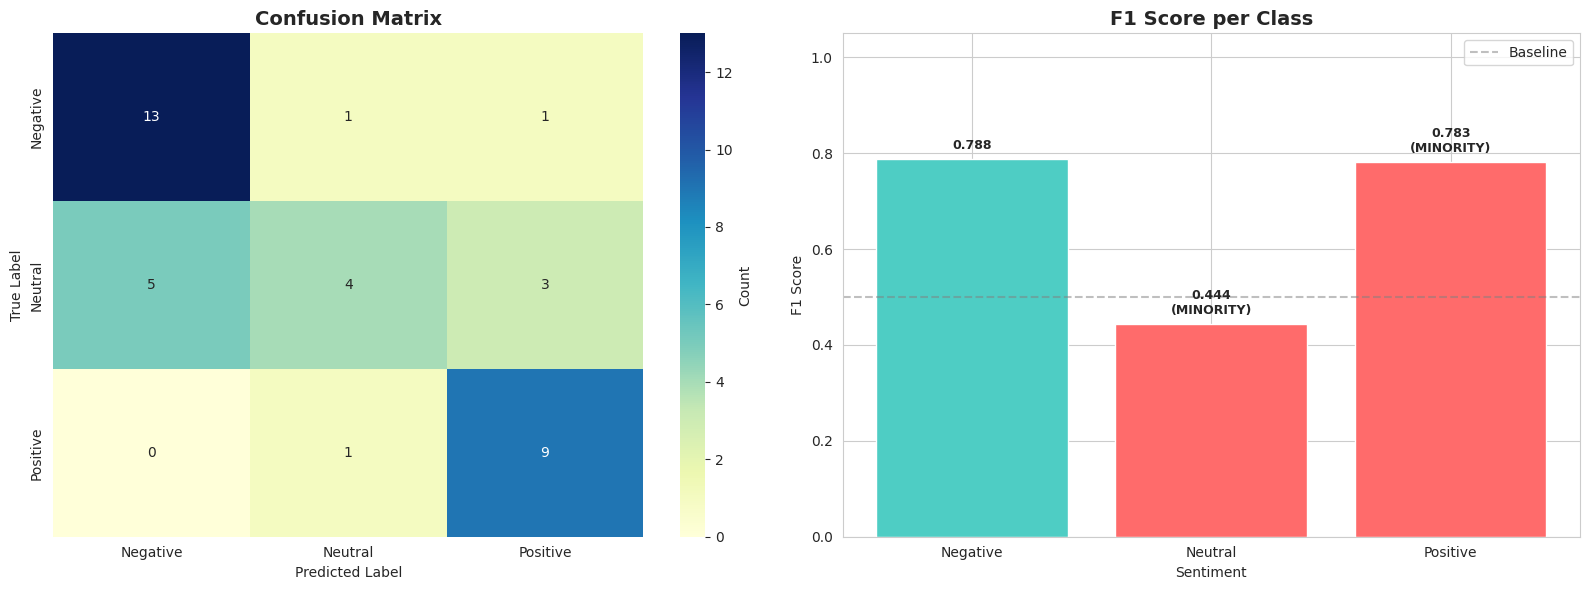

In [25]:
print(f"\n{'='*80}")
print(f"RESULT VISUALIZATIONS")
print(f"{'='*80}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_val, pred_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title("Confusion Matrix", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Plot 2: F1 Scores per Class
if f1_per_class:
    colors_f1 = ['#FF6B6B' if i in minority_class_ids else '#4ECDC4'
                 for i in range(len(unique_labels))]
    bars = axes[1].bar(f1_per_class.keys(), f1_per_class.values(), color=colors_f1)
    axes[1].set_title("F1 Score per Class", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("F1 Score")
    axes[1].set_xlabel("Sentiment")
    axes[1].set_ylim([0, 1.05])
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline')

    # Add value labels on bars
    for i, (k, v) in enumerate(f1_per_class.items()):
        class_id = label2id[k]
        label_text = f'{v:.3f}'
        if class_id in minority_class_ids:
            label_text += '\n(MINORITY)'
        axes[1].text(i, v + 0.02, label_text, ha='center', fontweight='bold', fontsize=9)

    axes[1].legend()

plt.tight_layout()
plt.show()


In [26]:
print(f"\n{'='*80}")
print(f"MINORITY CLASS PERFORMANCE ANALYSIS")
print(f"{'='*80}")

if len(minority_class_ids) > 0:
    print(f"\nDetailed analysis of minority classes:")

    for class_id in minority_class_ids:
        class_name = id2label[class_id]

        # Get predictions for this class
        true_mask = np.array(y_val) == class_id
        if true_mask.sum() == 0:
            continue

        true_count = true_mask.sum()
        pred_mask = pred_labels == class_id
        correct = ((np.array(y_val) == class_id) & (pred_labels == class_id)).sum()

        precision = correct / pred_mask.sum() if pred_mask.sum() > 0 else 0
        recall = correct / true_count
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n{class_name}:")
        print(f"  Total samples in validation: {true_count}")
        print(f"  Correctly predicted: {correct}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")

        # Show some examples
        print(f"\n  Example predictions:")
        class_indices = np.where(true_mask)[0][:3]  # First 3 examples
        for idx in class_indices:
            true_label = id2label[y_val[idx]]
            pred_label = id2label[pred_labels[idx]]
            correct_mark = "✓" if true_label == pred_label else "✗"
            print(f"    {correct_mark} True: {true_label}, Predicted: {pred_label}")
            print(f"      Text: {X_val[idx][:150]}...")
else:
    print("\n  No minority classes detected in this dataset.")
    print("All classes have similar sample counts.")



MINORITY CLASS PERFORMANCE ANALYSIS

Detailed analysis of minority classes:

Positive:
  Total samples in validation: 10
  Correctly predicted: 9
  Precision: 0.6923
  Recall: 0.9000
  F1-Score: 0.7826

  Example predictions:
    ✓ True: Positive, Predicted: Positive
      Text: good good good good...
    ✓ True: Positive, Predicted: Positive
      Text: very good. good. satisfactory. good....
    ✓ True: Positive, Predicted: Positive
      Text: very good very good very good excellent...

Neutral:
  Total samples in validation: 12
  Correctly predicted: 4
  Precision: 0.6667
  Recall: 0.3333
  F1-Score: 0.4444

  Example predictions:
    ✓ True: Neutral, Predicted: Neutral
      Text: everything was good regarding to university but, some lecturers don't have grip on the subject and lag in the teaching good very good excellent...
    ✗ True: Neutral, Predicted: Positive
      Text: Good Good Good Very good...
    ✓ True: Neutral, Predicted: Neutral
      Text: average good good good..

In [27]:
print(f"\n{'='*80}")
print(f"SAVING MODEL AND ARTIFACTS")
print(f"{'='*80}")

# Save model
output_dir = "./final_feedback_classifier"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✓ Model saved to: {output_dir}")

# Save label mappings
import json
with open(f"{output_dir}/label_mappings.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)
print(f"✓ Label mappings saved")

# Save minority pattern indices
minority_patterns_data = {
    "outlier_indices": outliers_idx.tolist(),  # Convert NumPy array to list
    "minority_cluster_indices": np.where(minority_cluster_idx)[0].tolist(), # Convert NumPy array to list
    "minority_cluster_ids": [int(cid) for cid in minority_cluster_ids], # Convert NumPy integers to standard integers
    "total_minority_patterns": len(all_minority_idx),
    "percentage": float(len(all_minority_idx) / len(df) * 100)
}

with open("./minority_patterns.json", "w") as f:
    json.dump(minority_patterns_data, f, indent=2)
print(f"✓ Minority pattern data saved to: ./minority_patterns.json")

# Save embeddings
np.save("./embeddings.npy", embeddings)
np.save("./embeddings_2d.npy", emb_2d)
print(f"✓ Embeddings saved")


SAVING MODEL AND ARTIFACTS
✓ Model saved to: ./final_feedback_classifier
✓ Label mappings saved
✓ Minority pattern data saved to: ./minority_patterns.json
✓ Embeddings saved


In [28]:
print(f"\n{'='*80}")
print(f"EXAMPLE PREDICTIONS ON NEW TEXT")
print(f"{'='*80}")

# Test examples
test_examples = [
    "This course was absolutely amazing! The professor was engaging and the material was fascinating.",
    "Terrible experience. The lectures were boring and I learned nothing useful.",
    "It was okay, not great but not terrible either. Some parts were interesting.",
    "I have mixed feelings about this class. Good content but poor delivery.",
    "The professor is outstanding! Best class I've ever taken!"
]

print("\nMaking predictions on example texts:\n")

device = next(model.parameters()).device
model.eval()

for i, text in enumerate(test_examples, 1):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0]
        pred_id = torch.argmax(probs).item()
        pred_label = id2label[pred_id]
        confidence = probs[pred_id].item()

    print(f"{i}. Text: {text[:100]}...")
    print(f"   Prediction: {pred_label} (confidence: {confidence:.2%})")
    print(f"   All probabilities:")
    for label_id, label_name in id2label.items():
        print(f"     {label_name}: {probs[label_id].item():.2%}")
    print()


EXAMPLE PREDICTIONS ON NEW TEXT

Making predictions on example texts:

1. Text: This course was absolutely amazing! The professor was engaging and the material was fascinating....
   Prediction: Positive (confidence: 90.97%)
   All probabilities:
     Negative: 0.66%
     Neutral: 8.37%
     Positive: 90.97%

2. Text: Terrible experience. The lectures were boring and I learned nothing useful....
   Prediction: Positive (confidence: 48.86%)
   All probabilities:
     Negative: 18.19%
     Neutral: 32.95%
     Positive: 48.86%

3. Text: It was okay, not great but not terrible either. Some parts were interesting....
   Prediction: Negative (confidence: 44.36%)
   All probabilities:
     Negative: 44.36%
     Neutral: 41.92%
     Positive: 13.72%

4. Text: I have mixed feelings about this class. Good content but poor delivery....
   Prediction: Negative (confidence: 52.79%)
   All probabilities:
     Negative: 52.79%
     Neutral: 24.54%
     Positive: 22.67%

5. Text: The professor is ou

In [29]:
print(f"\n{'='*80}")
print(f"PROJECT SUMMARY")
print(f"{'='*80}")

print(f"\n DATASET STATISTICS:")
print(f"  Total samples: {len(df)}")
print(f"  Number of classes: {len(unique_labels)}")
print(f"  Classes: {', '.join(unique_labels)}")

print(f"\n UNSUPERVISED PATTERN DISCOVERY:")
print(f"  Outliers found: {len(outliers_idx)} ({len(outliers_idx)/len(df)*100:.1f}%)")
print(f"  Clusters found: {n_clusters}")
print(f"  Minority clusters: {len(minority_cluster_ids)}")
print(f"  Total minority patterns: {len(all_minority_idx)} ({len(all_minority_idx)/len(df)*100:.1f}%)")

print(f"\n CLASSIFICATION PERFORMANCE:")
print(f"  Macro F1: {results.get('eval_f1_macro', 0):.4f}")
print(f"  Weighted F1: {results.get('eval_f1_weighted', 0):.4f}")
print(f"  Minority F1 Mean: {results.get('eval_minority_f1_mean', 0):.4f}")

if len(minority_class_ids) > 0:
    print(f"\n  Minority classes protected:")
    for class_id in minority_class_ids:
        class_name = id2label[class_id]
        count = Counter(y_train)[class_id]
        if class_name in f1_per_class:
            print(f"    {class_name}: {count} samples, F1 = {f1_per_class[class_name]:.4f}")
else:
    print(f"\n    No minority classes detected - all classes balanced")

print(f"\n RECOMMENDATIONS:")
if results.get('eval_minority_f1_mean', 0) < 0.5 and len(minority_class_ids) > 0:
    print(f"  • Minority F1 is low - consider collecting more data for minority classes")
    print(f"  • Try data augmentation techniques for minority classes")
    print(f"  • Experiment with different class weight values")
elif len(unique_labels) == 1:
    print(f"  • Dataset has only one class - adjust rating thresholds to create more classes")
    print(f"  • Consider using quantile-based splitting for better class balance")
else:
    print(f"  ✓ Model performs well on minority classes!")
    print(f"  ✓ Ready for deployment")

print(f"\n SAVED ARTIFACTS:")
print(f"  • Model: {output_dir}/")
print(f"  • Minority patterns: ./minority_patterns.json")
print(f"  • Embeddings: ./embeddings.npy, ./embeddings_2d.npy")

print(f"\n{'='*80}")
print(f" PIPELINE COMPLETE!")
print(f"{'='*80}")
print("\nNext steps:")
print("1. Review minority patterns in the visualization")
print("2. Analyze misclassified minority samples")
print("3. Consider collecting more data for underrepresented classes")
print("4. Deploy model using the saved artifacts")
print("\nTo load the model later:")
print(f"  from transformers import AutoTokenizer, AutoModelForSequenceClassification")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{output_dir}')")
print(f"  model = AutoModelForSequenceClassification.from_pretrained('{output_dir}')")


PROJECT SUMMARY

 DATASET STATISTICS:
  Total samples: 185
  Number of classes: 3
  Classes: Negative, Neutral, Positive

 UNSUPERVISED PATTERN DISCOVERY:
  Outliers found: 15 (8.1%)
  Clusters found: 3
  Minority clusters: 1
  Total minority patterns: 24 (13.0%)

 CLASSIFICATION PERFORMANCE:
  Macro F1: 0.6716
  Weighted F1: 0.6751
  Minority F1 Mean: 0.6135

  Minority classes protected:
    Positive: 39 samples, F1 = 0.7826
    Neutral: 49 samples, F1 = 0.4444

 RECOMMENDATIONS:
  ✓ Model performs well on minority classes!
  ✓ Ready for deployment

 SAVED ARTIFACTS:
  • Model: ./final_feedback_classifier/
  • Minority patterns: ./minority_patterns.json
  • Embeddings: ./embeddings.npy, ./embeddings_2d.npy

 PIPELINE COMPLETE!

Next steps:
1. Review minority patterns in the visualization
2. Analyze misclassified minority samples
3. Consider collecting more data for underrepresented classes
4. Deploy model using the saved artifacts

To load the model later:
  from transformers import

In [30]:
print(f"\n{'='*80}")
print(f"EXPORTING MINORITY PATTERNS")
print(f"{'='*80}")

# Create DataFrame with minority patterns
minority_df = df.iloc[all_minority_idx].copy()
minority_df['is_outlier'] = minority_df.index.isin(outliers_idx)
minority_df['is_minority_cluster'] = minority_df.index.isin(np.where(minority_cluster_idx)[0])
minority_df['cluster_id'] = [cluster_labels[i] for i in all_minority_idx]

# Export to CSV
minority_csv_path = "./minority_patterns.csv"
minority_df[[TEXT_COL, LABEL_COL, 'is_outlier', 'is_minority_cluster', 'cluster_id']].to_csv(
    minority_csv_path, index=False
)
print(f"✓ Minority patterns exported to: {minority_csv_path}")
print(f"  Total patterns: {len(minority_df)}")
print(f"  Columns: {minority_df.columns.tolist()}")

print(f"\n{'='*80}")
print(f"ALL DONE! ")
print(f"{'='*80}")


EXPORTING MINORITY PATTERNS
✓ Minority patterns exported to: ./minority_patterns.csv
  Total patterns: 24
  Columns: ['teaching', 'teaching.1', 'coursecontent', 'coursecontent.1', 'examination', 'Examination', 'labwork', 'labwork.1', 'library_facilities', ' library_facilities', 'extracurricular', 'extracurricular.1', 'text', 'avg_rating', 'sentiment', 'text_len', 'label_id', 'is_outlier', 'is_minority_cluster', 'cluster_id']

ALL DONE! 


In [59]:
# --------------------------------------------------------------
# 1. Install the tiny helper library (nbformat)
# --------------------------------------------------------------
!pip install -q nbformat

# --------------------------------------------------------------
# 2. IMPORTS
# --------------------------------------------------------------
import nbformat
import json
from pathlib import Path
import urllib.request
from google.colab import files

# --------------------------------------------------------------
# 3. CONFIG – change these two lines
# --------------------------------------------------------------
# <-- PUT YOUR RAW GITHUB URL HERE (must end with .ipynb) -->
RAW_URL = "https://raw.githubusercontent.com/ahmedElmersawy/StudentFeedbackMinorityPatternsDiscovery/main/StudentFeedbackAnalysis%20(2).ipynb"

# Name of the fixed file that will be created
FIXED_NAME = "StudentFeedbackAnalysis_fixed.ipynb"

# --------------------------------------------------------------
# 4. DOWNLOAD the notebook
# --------------------------------------------------------------
tmp_path = Path("/tmp/bad.ipynb")
urllib.request.urlretrieve(RAW_URL, tmp_path)
print(f"Downloaded notebook → {tmp_path}")

# --------------------------------------------------------------
# 5. LOAD & CLEAN
# --------------------------------------------------------------
nb = nbformat.read(tmp_path, as_version=4)

def remove_widgets(obj):
    """Recursively delete any 'widgets' key that lacks a 'state'."""
    if isinstance(obj, dict):
        if "widgets" in obj:
            # If the whole widgets dict is broken, just delete it
            del obj["widgets"]
        else:
            for v in obj.values():
                remove_widgets(v)
    elif isinstance(obj, list):
        for item in obj:
            remove_widgets(item)

remove_widgets(nb)

# --------------------------------------------------------------
# 6. SAVE the fixed notebook
# --------------------------------------------------------------
fixed_path = Path("/tmp") / FIXED_NAME
nbformat.write(nb, fixed_path)
print(f"Clean notebook saved → {fixed_path}")

# --------------------------------------------------------------
# 7. DOWNLOAD the fixed file (click the link that appears)
# --------------------------------------------------------------
files.download(fixed_path)

Downloaded notebook → /tmp/bad.ipynb
Clean notebook saved → /tmp/StudentFeedbackAnalysis_fixed.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>